## Set up

Set up the code

In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

# Local imports
from src import process

In [3]:
# Load data
blind_mode_df, estimates_df = process.load_and_process_results(
    fix_bad_rows=True, remove_bad_rows=True
)
blind_mode_feature_df = process.get_feature_df(blind_mode_df)
markets_df = process.get_current_probs()
resolution_vector = process.get_target_df(df_format=False)
estimates_matrix = process.get_estimates_matrix(blind_mode_df)
brier_score = np.mean(np.square(estimates_matrix - resolution_vector), axis=1)
blind_mode_df["brier_score"] = brier_score

# Set up data

# Create a new dataframe with the columns we want to use
columns_to_use = blind_mode_feature_df.columns.tolist()
blind_mode_df_xgboost = blind_mode_feature_df[columns_to_use]
blind_mode_df_xgboost.head()

# Remove rows with NaNs
# blind_mode_df_xgboost.dropna(inplace=True)
# blind_mode_df_xgboost.shape

# Create the X and y arrays
X = blind_mode_df_xgboost
# Assign the column names to the X array
y = blind_mode_df["brier_score"]

Loading current probabilities from file


In [4]:
# Split into train and test sets
random_seed = 1337 # np.random.randint(100000)
print(f"Random seed: {random_seed}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_seed, test_size=0.2
)


# cuda not working yet
# Transfer data to GPU if available
device = "cpu"  # "cuda" if torch.cuda.is_available() else "cpu"
X_train_device = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_device = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_device = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_device = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Random seed: 1337


## Base Model

RMSE: 0.04618453208275385


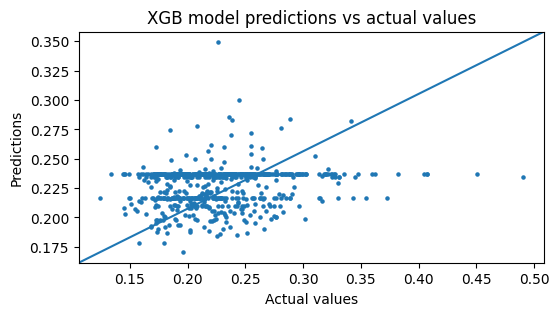

In [5]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# XGBoost model predictions vs actual values
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.scatter(y_test, y_pred, s=5)
ax.set_title("XGB model predictions vs actual values")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predictions")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.show()

## Hyperopt

In [6]:
# Define the space over which hyperopt will search for optimal hyperparameters
space = {
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "lambda": hp.uniform("lambda", 0, 1),
    "alpha": hp.uniform("alpha", 0, 1),
    "max_depth": scope.int(hp.quniform("max_depth", 1, 5, 1)),
    "gamma": hp.uniform("gamma", 0, 1),
    # "reg_alpha": hp.uniform("reg_alpha", 0, 50),
    # "reg_lambda": hp.uniform("reg_lambda", 10, 100),
    # "colsample_bytree": hp.uniform("colsample_bytree", 0, 1),
    "min_child_weight": hp.uniform("min_child_weight", 0, 5),
    # "n_estimators": 10000,
    # "tree_method": "gpu_hist",
    # "gpu_id": 0,
    # "max_bin": scope.int(hp.quniform("max_bin", 200, 550, 1)),
    # "early_stopping_rounds": 100,
    "objective": "reg:squarederror",
    "random_state": 42,
    "device": device,
}

In [7]:
# Define the hyperopt objective
def hyperparameter_tuning(space, verbose=False):
    model = xgb.XGBRegressor(**space)

    evaluation = [(X_train, y_train), (X_test, y_test)]
    # Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(
        X_train,
        y_train,
        eval_set=evaluation,
        verbose=False,
    )
    # Obtain prediction and mse score.
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    if verbose:
        print(f"MSE: {mse}")
    # Specify what the loss is for each model.
    return {"loss": mse, "status": STATUS_OK, "model": model}

In [8]:
# Run trials
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
)
print(f"Best hyperparameters: {best}")
# best loss: 0.002023386858235994

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:11<00:00,  8.34trial/s, best loss: 0.0020299630359116552]
Best hyperparameters: {'alpha': 0.35663543566116795, 'gamma': 0.005997467172071246, 'lambda': 0.370098278321425, 'learning_rate': 0.1982493944040046, 'max_depth': 2.0, 'min_child_weight': 3.310164889985418}


In [11]:
# Create instace of best model.
best_model = trials.results[np.argmin([r["loss"] for r in trials.results])]["model"]
# Examine model hyperparameters
print(
    f"Final loss (MSE): {trials.results[np.argmin([r['loss'] for r in trials.results])]['loss']:.8f}"
)
print(f"Best model hyperparameters:\n{best}")

# Final loss (MSE): 0.00202996
# Best model hyperparameters:
# {'alpha': 0.35663543566116795, 'gamma': 0.005997467172071246, 'lambda': 0.370098278321425, 'learning_rate': 0.1982493944040046, 'max_depth': 2.0, 'min_child_weight': 3.310164889985418}

Final loss (MSE): 0.00202996
Best model hyperparameters:
{'alpha': 0.35663543566116795, 'gamma': 0.005997467172071246, 'lambda': 0.370098278321425, 'learning_rate': 0.1982493944040046, 'max_depth': 2.0, 'min_child_weight': 3.310164889985418}


In [10]:
xgb_standard = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=42, device=device
).fit(X_train, y_train)

xgb_score_best = root_mean_squared_error(y_test, best_model.predict(X_test))
print("Best Model MSE:", xgb_score_best)
standard_score = root_mean_squared_error(y_test, xgb_standard.predict(X_test))
print("Base model MSE:", standard_score)

# MSE from guessing the mean of the training set
mean_guess = np.mean(y_train)
mean_guess_mse = root_mean_squared_error(y_test, np.full(y_test.shape, mean_guess))
print("Mean model MSE:", mean_guess_mse)

Best Model MSE: 0.04505511109643006
Base model MSE: 0.04618453208275385
Mean model MSE: 0.04599025359912
